# 日経平均株価 日足

In [1]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = '^N225'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-08-07 00:00:00+09:00,34122.351562,35849.769531,33739.460938,35089.621094,242800000,0.0,0.0
2024-08-08 00:00:00+09:00,34645.789062,35379.648438,34207.160156,34831.148438,165300000,0.0,0.0
2024-08-09 00:00:00+09:00,35272.339844,35671.308594,34445.570312,35025.000000,176900000,0.0,0.0
2024-08-13 00:00:00+09:00,35490.578125,36232.511719,35476.789062,36232.511719,140700000,0.0,0.0
2024-08-14 00:00:00+09:00,36535.601562,36683.890625,36074.710938,36442.429688,135600000,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-03 00:00:00+09:00,38932.660156,38948.609375,38401.820312,38520.089844,169200000,0.0,0.0
2025-02-04 00:00:00+09:00,39078.660156,39192.511719,38590.960938,38798.371094,144300000,0.0,0.0
2025-02-05 00:00:00+09:00,38979.210938,39118.949219,38682.179688,38831.480469,151200000,0.0,0.0


In [2]:
df0 = ticker.history(period='5y', interval='1d')
df0

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-02-07 00:00:00+09:00,23899.009766,23943.449219,23759.419922,23827.980469,65400000,0.0,0.0
2020-02-10 00:00:00+09:00,23631.789062,23788.250000,23621.720703,23685.980469,56500000,0.0,0.0
2020-02-12 00:00:00+09:00,23741.210938,23869.730469,23693.720703,23861.210938,74600000,0.0,0.0
2020-02-13 00:00:00+09:00,23849.759766,23908.849609,23784.310547,23827.730469,64500000,0.0,0.0
2020-02-14 00:00:00+09:00,23714.519531,23738.419922,23603.480469,23687.589844,69100000,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-03 00:00:00+09:00,38932.660156,38948.609375,38401.820312,38520.089844,169200000,0.0,0.0
2025-02-04 00:00:00+09:00,39078.660156,39192.511719,38590.960938,38798.371094,144300000,0.0,0.0
2025-02-05 00:00:00+09:00,38979.210938,39118.949219,38682.179688,38831.480469,151200000,0.0,0.0


## パラボリック SAR

In [3]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートと Parabolic SAR

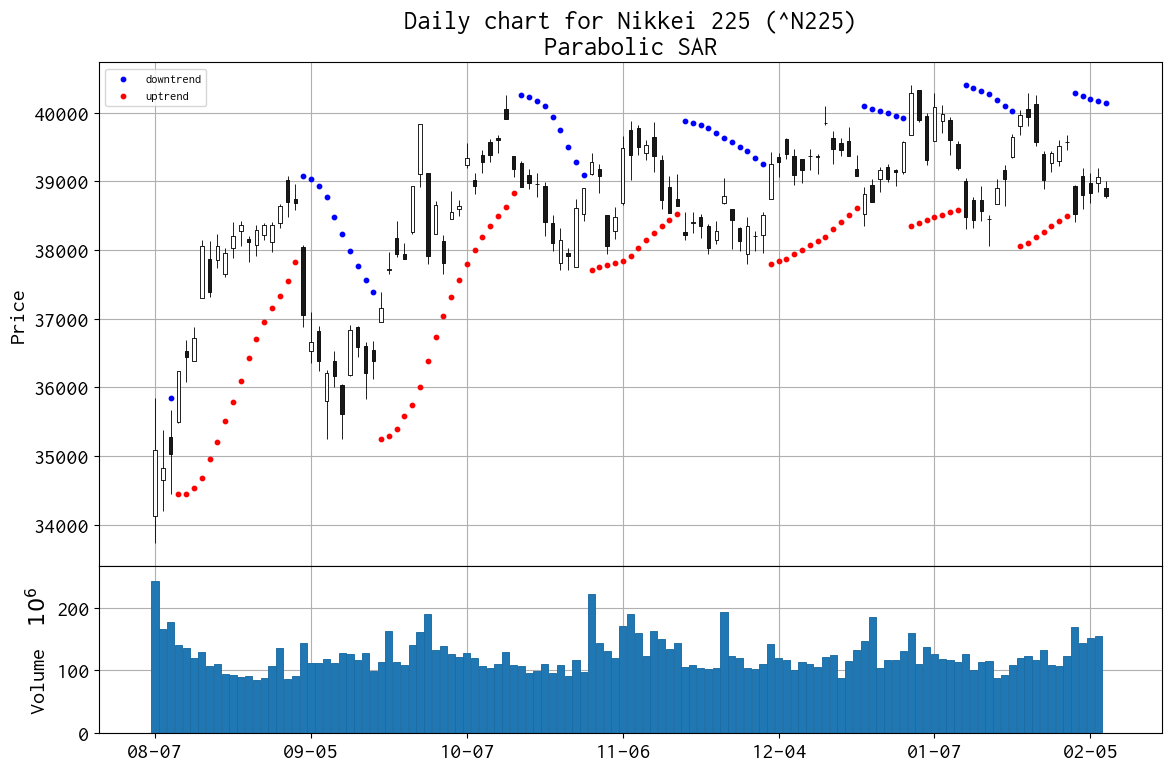

In [4]:
dict_psar = psar(df)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 8))
#ax = fig.add_subplot(111)
ax = dict()
n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[3 if i == 0 else 1 for i in range(n)]
)
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

ma5 = df0['Close'].rolling(5).median()
ma25 = df0['Close'].rolling(25).median()
ma75 = df0['Close'].rolling(75).median()
ma200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=10,
        color='blue',
        label='downtrend',
        ax=ax[0]
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=10,
        color='red',
        label='uptrend',
        ax=ax[0]
    ),
    #mpf.make_addplot(ma5[df.index], width=1, label='  5 days', ax=ax[0]),
    #mpf.make_addplot(ma25[df.index], width=1, label=' 25 days', ax=ax[0]),
    #mpf.make_addplot(ma75[df.index], width=1, linestyle='dashed', label=' 75 days', ax=ax[0]),
    #mpf.make_addplot(ma200[df.index], width=1, linestyle='dotted', label='200 days', ax=ax[0]),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    volume=ax[1],
    datetime_format='%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax[0],
)
try:
    ax[0].set_title('Daily chart for %s (%s)\nParabolic SAR' % (ticker.info['longName'], symbol))
except KeyError:
    ax[0].set_title('Daily chart for %s\nParabolic SAR' % symbol)

#ax.grid()
ax[0].legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig('daily_chart_n225.png')
plt.show()

In [5]:
df.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-02-07 00:00:00+09:00,38907.761719,39007.941406,38753.199219,38787.019531,0,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-01-30 00:00:00+09:00    39513.968750
2025-01-31 00:00:00+09:00    39572.488281
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-01-30 00:00:00+09:00          NaN
2025-01-31 00:00:00+09:00    58.519531
Name: Close, dtype: float64

In [8]:
df['Close'].rolling(25).mean()

Date
2024-07-31 00:00:00+09:00             NaN
2024-08-01 00:00:00+09:00             NaN
2024-08-02 00:00:00+09:00             NaN
2024-08-05 00:00:00+09:00             NaN
2024-08-06 00:00:00+09:00             NaN
                                 ...     
2025-01-27 00:00:00+09:00    39287.098750
2025-01-28 00:00:00+09:00    39273.186406
2025-01-29 00:00:00+09:00    39286.509219
2025-01-30 00:00:00+09:00    39314.524844
2025-01-31 00:00:00+09:00    39349.348437
Name: Close, Length: 123, dtype: float64

In [9]:
df['Close'].rolling(100).mean()

Date
2024-07-31 00:00:00+09:00             NaN
2024-08-01 00:00:00+09:00             NaN
2024-08-02 00:00:00+09:00             NaN
2024-08-05 00:00:00+09:00             NaN
2024-08-06 00:00:00+09:00             NaN
                                 ...     
2025-01-27 00:00:00+09:00    38660.793750
2025-01-28 00:00:00+09:00    38667.244844
2025-01-29 00:00:00+09:00    38677.767344
2025-01-30 00:00:00+09:00    38686.429531
2025-01-31 00:00:00+09:00    38695.145703
Name: Close, Length: 123, dtype: float64